##                                                  Курсовой проект

**Задача**

Требуется, на основании имеющихся данных о клиентах банка, построить модель, используя обучающий датасет, для прогнозирования невыполнения долговых обязательств по текущему кредиту. Выполнить прогноз для примеров из тестового датасета.

**Наименование файлов с данными**

course_project_train.csv - обучающий датасет<br>
course_project_test.csv - тестовый датасет

**Целевая переменная**

Credit Default - факт невыполнения кредитных обязательств

**Метрика качества**

F1-score (sklearn.metrics.f1_score)

**Требования к решению**

*Целевая метрика*
* F1($\beta$ = 1) > 0.5 при Precision > 0.5 и Recall > 0.5
* Метрика оценивается по качеству прогноза для главного класса (1 - просрочка по кредиту)

*Решение должно содержать*
1. Тетрадка Jupyter Notebook с кодом Вашего решения, названная по образцу {ФИО}\_solution.ipynb, пример SShirkin\_solution.ipynb
2. Файл CSV с прогнозами целевой переменной **(0 или 1, а НЕ вероятность)** для тестового датасета, названный по образцу {ФИО}\_predictions.csv, пример SShirkin\_predictions.csv

*Рекомендации для файла с кодом (ipynb)*
1. Файл должен содержать заголовки и комментарии (markdown)
2. Повторяющиеся операции лучше оформлять в виде функций
3. Не делать вывод большого количества строк таблиц (5-10 достаточно)
4. По возможности добавлять графики, описывающие данные (около 3-5)
5. Добавлять только лучшую модель, то есть не включать в код все варианты решения проекта
6. Скрипт проекта должен отрабатывать от начала и до конца (от загрузки данных до выгрузки предсказаний)
7. Весь проект должен быть в одном скрипте (файл ipynb).
8. Допускается применение библиотек Python и моделей машинного обучения,
которые были в данном курсе.

**Сроки сдачи**

Cдать проект нужно в течение 5 дней после окончания последнего вебинара.
Оценки работ, сданных до дедлайна, будут представлены в виде рейтинга, ранжированного по заданной метрике качества.
Проекты, сданные после дедлайна или сданные повторно, не попадают в рейтинг, но можно будет узнать результат.

Cдать проект нужно в течение 5 дней после окончания последнего вебинара. Оценки работ, сданных до дедлайна, будут представлены в виде рейтинга, ранжированного по заданной метрике качества. Проекты, сданные после дедлайна или сданные повторно, не попадают в рейтинг, но можно будет узнать результат.
Примерное описание этапов выполнения курсового проекта

**Построение модели классификации**

*    Обзор обучающего датасета
*    Обработка выбросов
*    Обработка пропусков
*    Анализ данных
*    Отбор признаков
*    Балансировка классов
*    Подбор моделей, получение бейзлана
*    Выбор наилучшей модели, настройка гиперпараметров
*    Проверка качества, борьба с переобучением
*    Интерпретация результатов

**Прогнозирование на тестовом датасете**

    Выполнить для тестового датасета те же этапы обработки и постронияния признаков
    Спрогнозировать целевую переменную, используя модель, построенную на обучающем датасете
    Прогнозы должны быть для всех примеров из тестового датасета (для всех строк)
    Соблюдать исходный порядок примеров из тестового датасета

**Обзор данных**

**Описание датасета**

*   **Home Ownership** - домовладение
*   **Annual Income** - годовой доход
*   **Years in current job** - количество лет на текущем месте работы
*   **Tax Liens** - налоговые обременения
*   **Number of Open Accounts** - количество открытых счетов
*   **Years of Credit History** - количество лет кредитной истории
*   **Maximum Open Credit** - наибольший открытый кредит
*   **Number of Credit Problems** - количество проблем с кредитом
*   **Months since last delinquent** - количество месяцев с последней просрочки платежа
*   **Bankruptcies** - банкротства
*   **Purpose** - цель кредита
*   **Term** - срок кредита
*   **Current Loan Amount** - текущая сумма кредита
*   **Current Credit Balance** - текущий кредитный баланс
*   **Monthly Debt** - ежемесячный долг
*   **Credit Default** - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)


In [250]:
import pandas as pd
import numpy as np
import pickle
import random

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb, lightgbm as lgbm, catboost as catb

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [251]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [252]:
def show_proba_calibration_plots(y_predicted_probs, y_true_labels):
    preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))

    thresholds = []
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in np.linspace(0.1, 0.9, 9):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        recalls.append(recall_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        f1_scores.append(f1_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))

    scores_table = pd.DataFrame({'f1':f1_scores,
                                 'precision':precisions,
                                 'recall':recalls,
                                 'probability':thresholds}).sort_values('f1', ascending=False).round(3)
  
    figure = plt.figure(figsize = (15, 5))

    plt1 = figure.add_subplot(121)
    plt1.axhline(0.5, color="red")
    plt1.plot(thresholds, precisions, label='Precision', linewidth=4)
    plt1.plot(thresholds, recalls, label='Recall', linewidth=4)
    plt1.plot(thresholds, f1_scores, label='F1', linewidth=4)
    plt1.set_ylabel('Scores')
    plt1.set_xlabel('Probability threshold')
    plt1.set_title('Probabilities threshold calibration')
    plt1.legend(bbox_to_anchor=(0.25, 0.25))   
    plt1.table(cellText = scores_table.values,
               colLabels = scores_table.columns, 
               colLoc = 'center', cellLoc = 'center', loc = 'bottom', bbox = [0, -1.3, 1, 1])

    plt2 = figure.add_subplot(122)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 0][:, 0], 
              label='Another class', color='royalblue', alpha=1)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 1][:, 0], 
              label='Main class', color='darkcyan', alpha=0.8)
    plt2.set_ylabel('Number of examples')
    plt2.set_xlabel('Probabilities')
    plt2.set_title('Probability histogram')
    plt2.legend(bbox_to_anchor=(1, 1))

    plt.show()

In [416]:
TRAIN_DATASET_PATH = 'course_project_train.csv'
TEST_DATASET_PATH = 'course_project_test.csv'

In [417]:
df_train = pd.read_csv(TRAIN_DATASET_PATH)
df_train.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


In [255]:
df_train.shape

(7500, 17)

In [256]:
df_train.iloc[0]

Home Ownership                            Own Home
Annual Income                               482087
Years in current job                           NaN
Tax Liens                                        0
Number of Open Accounts                         11
Years of Credit History                       26.3
Maximum Open Credit                         685960
Number of Credit Problems                        1
Months since last delinquent                   NaN
Bankruptcies                                     1
Purpose                         debt consolidation
Term                                    Short Term
Current Loan Amount                          1e+08
Current Credit Balance                       47386
Monthly Debt                                  7914
Credit Score                                   749
Credit Default                                   0
Name: 0, dtype: object

In [257]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

In [258]:
df_train['Credit Default'].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

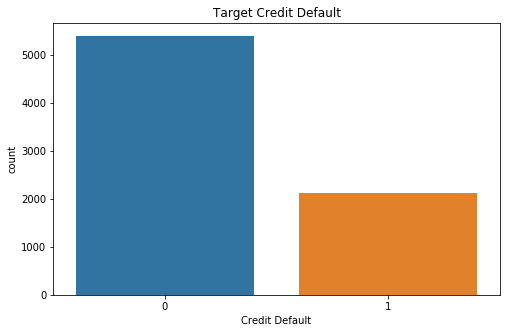

In [259]:
plt.figure(figsize=(8, 5))

sns.countplot(x='Credit Default', data=df_train)

plt.title('Target Credit Default')
plt.show()

In [260]:
df_test = pd.read_csv(TEST_DATASET_PATH)
df_test.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
0,Rent,NaN,4 years,0.0,9.0,12.5,220968.0,0.0,70.0,0.0,debt consolidation,Short Term,162470.0,105906.0,6813.0,NaN
1,Rent,231838.0,1 year,0.0,6.0,32.7,55946.0,0.0,8.0,0.0,educational expenses,Short Term,78298.0,46037.0,2318.0,699.0
2,Home Mortgage,1152540.0,3 years,0.0,10.0,13.7,204600.0,0.0,NaN,0.0,debt consolidation,Short Term,200178.0,146490.0,18729.0,7260.0
3,Home Mortgage,1220313.0,10+ years,0.0,16.0,17.0,456302.0,0.0,70.0,0.0,debt consolidation,Short Term,217382.0,213199.0,27559.0,739.0
4,Home Mortgage,2340952.0,6 years,0.0,11.0,23.6,1207272.0,0.0,NaN,0.0,debt consolidation,Long Term,777634.0,425391.0,42605.0,706.0


In [261]:
df_test.shape

(2500, 16)

In [262]:
df_train.dtypes

Home Ownership                   object
Annual Income                   float64
Years in current job             object
Tax Liens                       float64
Number of Open Accounts         float64
Years of Credit History         float64
Maximum Open Credit             float64
Number of Credit Problems       float64
Months since last delinquent    float64
Bankruptcies                    float64
Purpose                          object
Term                             object
Current Loan Amount             float64
Current Credit Balance          float64
Monthly Debt                    float64
Credit Score                    float64
Credit Default                    int64
dtype: object

In [263]:
df_test = pd.get_dummies(df_train, columns=['Home Ownership', 'Purpose', 'Term'])
df_test.head()

,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,...,Purpose_medical bills,Purpose_moving,Purpose_other,Purpose_renewable energy,Purpose_small business,Purpose_take a trip,Purpose_vacation,Purpose_wedding,Term_Long Term,Term_Short Term
0,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,99999999.0,...,0,0,0,0,0,0,0,0,0,1
1,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,264968.0,...,0,0,0,0,0,0,0,0,1,0
2,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,99999999.0,...,0,0,0,0,0,0,0,0,0,1
3,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,121396.0,...,0,0,0,0,0,0,0,0,0,1
4,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,125840.0,...,0,0,0,0,0,0,0,0,0,1


# Обработка пропусков

In [264]:
len(df_train) - df_train.count()

Home Ownership                     0
Annual Income                   1557
Years in current job             371
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    4081
Bankruptcies                      14
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                    1557
Credit Default                     0
dtype: int64

In [265]:
df_train[['Annual Income', 'Years in current job', 'Months since last delinquent', 'Months since last delinquent', 'Bankruptcies', 'Credit Score']].head(10)

,Annual Income,Years in current job,Months since last delinquent,Months since last delinquent,Bankruptcies,Credit Score
0,482087.0,NaN,NaN,NaN,1.0,749.0
1,1025487.0,10+ years,NaN,NaN,0.0,737.0
2,751412.0,8 years,NaN,NaN,0.0,742.0
3,805068.0,6 years,NaN,NaN,1.0,694.0
4,776264.0,8 years,NaN,NaN,0.0,719.0
5,NaN,7 years,NaN,NaN,0.0,NaN
6,1511108.0,10+ years,73.0,73.0,0.0,745.0
7,1040060.0,10+ years,18.0,18.0,0.0,705.0
8,NaN,5 years,NaN,NaN,1.0,NaN
9,NaN,1 year,6.0,6.0,0.0,NaN


In [266]:
df_train.loc[df_train['Annual Income'].isnull(), 'Annual Income'] = df_train['Annual Income'].median()

In [267]:
df_train.loc[df_train['Months since last delinquent'].isnull(), 'Months since last delinquent'] = df_train['Months since last delinquent'].median()

In [268]:
df_train.loc[df_train['Bankruptcies'].isnull(), 'Bankruptcies'] = df_train['Bankruptcies'].median()

In [269]:
df_train.loc[df_train['Credit Score'].isnull(), 'Credit Score'] = df_train['Credit Score'].median()

In [270]:
df_train['Years in current job'].head()

0          NaN
1    10+ years
2      8 years
3      6 years
4      8 years
Name: Years in current job, dtype: object

In [271]:
df_train.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,32.0,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,32.0,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,32.0,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,32.0,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,32.0,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


In [272]:
df_train.dtypes

Home Ownership                   object
Annual Income                   float64
Years in current job             object
Tax Liens                       float64
Number of Open Accounts         float64
Years of Credit History         float64
Maximum Open Credit             float64
Number of Credit Problems       float64
Months since last delinquent    float64
Bankruptcies                    float64
Purpose                          object
Term                             object
Current Loan Amount             float64
Current Credit Balance          float64
Monthly Debt                    float64
Credit Score                    float64
Credit Default                    int64
dtype: object

In [273]:
df_train.loc[df_train['Years in current job'].str.len() <= 1] = np.nan
df_train.loc[df_train['Years in current job'].str.len() > 1, 'Years in current job'] = df_train[df_train['Years in current job'].str.len() > 1]['Years in current job'].str.split(' ', expand=True)[0]
df_train.loc[:, 'Years in current job'] = df_train['Years in current job'].str.replace('.', '')
df_train.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,32.0,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0.0
1,Own Home,1025487.0,10+,0.0,15.0,15.3,1181730.0,0.0,32.0,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1.0
2,Home Mortgage,751412.0,8,0.0,11.0,35.0,1182434.0,0.0,32.0,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0.0
3,Own Home,805068.0,6,0.0,8.0,22.5,147400.0,1.0,32.0,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0.0
4,Rent,776264.0,8,0.0,13.0,13.6,385836.0,1.0,32.0,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0.0


In [274]:
df_train['Years in current job'] = df_train['Years in current job'].fillna(0)

In [275]:
df_train['Years in current job'].str.strip()

0       NaN
1       10+
2         8
3         6
4         8
       ... 
7495      <
7496      1
7497      6
7498    NaN
7499      4
Name: Years in current job, Length: 7500, dtype: object

In [276]:
df_train['Years in current job'].replace('10+','10',inplace=True)

In [277]:
df_train['Years in current job'].replace('<','0',inplace=True)

In [278]:
for colname in ['Years in current job']:
    df_train[colname] = df_train[colname].astype(str)

In [279]:
 df_train['Years in current job'] = df_train['Years in current job'].astype('float64') 

In [280]:
df_train['Years in current job'] = df_train['Years in current job'].fillna(0)

In [281]:
len(df_train) - df_train.count()

Home Ownership                  0
Annual Income                   0
Years in current job            0
Tax Liens                       0
Number of Open Accounts         0
Years of Credit History         0
Maximum Open Credit             0
Number of Credit Problems       0
Months since last delinquent    0
Bankruptcies                    0
Purpose                         0
Term                            0
Current Loan Amount             0
Current Credit Balance          0
Monthly Debt                    0
Credit Score                    0
Credit Default                  0
dtype: int64

In [282]:
df_train.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,0.0,0.0,11.0,26.3,685960.0,1.0,32.0,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0.0
1,Own Home,1025487.0,10.0,0.0,15.0,15.3,1181730.0,0.0,32.0,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1.0
2,Home Mortgage,751412.0,8.0,0.0,11.0,35.0,1182434.0,0.0,32.0,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0.0
3,Own Home,805068.0,6.0,0.0,8.0,22.5,147400.0,1.0,32.0,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0.0
4,Rent,776264.0,8.0,0.0,13.0,13.6,385836.0,1.0,32.0,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0.0


In [283]:
df_train.dtypes

Home Ownership                   object
Annual Income                   float64
Years in current job            float64
Tax Liens                       float64
Number of Open Accounts         float64
Years of Credit History         float64
Maximum Open Credit             float64
Number of Credit Problems       float64
Months since last delinquent    float64
Bankruptcies                    float64
Purpose                          object
Term                             object
Current Loan Amount             float64
Current Credit Balance          float64
Monthly Debt                    float64
Credit Score                    float64
Credit Default                  float64
dtype: object

In [284]:
for col in df_train.columns:
    pct_missing = np.mean(df_train[col].isnull())
    print('{} - {}%'.format(col, round(pct_missing*100)))

Home Ownership - 0.0%
Annual Income - 0.0%
Years in current job - 0.0%
Tax Liens - 0.0%
Number of Open Accounts - 0.0%
Years of Credit History - 0.0%
Maximum Open Credit - 0.0%
Number of Credit Problems - 0.0%
Months since last delinquent - 0.0%
Bankruptcies - 0.0%
Purpose - 0.0%
Term - 0.0%
Current Loan Amount - 0.0%
Current Credit Balance - 0.0%
Monthly Debt - 0.0%
Credit Score - 0.0%
Credit Default - 0.0%


In [285]:
for cat_colname in df_train.select_dtypes(include='object').columns:
    print(str(cat_colname) + '\n\n' + str(df_train[cat_colname].value_counts()) + '\n' + '*' * 100 + '\n')

Home Ownership

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64
****************************************************************************************************

Purpose

debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses      10
vacation                   8
renewable energy           2
Name: Purpose, dtype: int64
****************************************************************************************************

Term

Short Term    5556
Long Term     1944
Name: Term, dtype: int64
****************************************************************************************************



In [286]:
df_train.shape[1]-1 == df_test.shape[1]

False

In [287]:
cat_colnames = df_train.select_dtypes(include='object').columns.tolist()
cat_colnames

['Home Ownership', 'Purpose', 'Term']

In [288]:
df_train.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,0.0,0.0,11.0,26.3,685960.0,1.0,32.0,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0.0
1,Own Home,1025487.0,10.0,0.0,15.0,15.3,1181730.0,0.0,32.0,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1.0
2,Home Mortgage,751412.0,8.0,0.0,11.0,35.0,1182434.0,0.0,32.0,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0.0
3,Own Home,805068.0,6.0,0.0,8.0,22.5,147400.0,1.0,32.0,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0.0
4,Rent,776264.0,8.0,0.0,13.0,13.6,385836.0,1.0,32.0,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0.0


In [289]:
df_train = pd.get_dummies(df_train, columns=['Home Ownership', 'Purpose', 'Term'])
df_train.head()

,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,...,Purpose_medical bills,Purpose_moving,Purpose_other,Purpose_renewable energy,Purpose_small business,Purpose_take a trip,Purpose_vacation,Purpose_wedding,Term_Long Term,Term_Short Term
0,482087.0,0.0,0.0,11.0,26.3,685960.0,1.0,32.0,1.0,99999999.0,...,0,0,0,0,0,0,0,0,0,1
1,1025487.0,10.0,0.0,15.0,15.3,1181730.0,0.0,32.0,0.0,264968.0,...,0,0,0,0,0,0,0,0,1,0
2,751412.0,8.0,0.0,11.0,35.0,1182434.0,0.0,32.0,0.0,99999999.0,...,0,0,0,0,0,0,0,0,0,1
3,805068.0,6.0,0.0,8.0,22.5,147400.0,1.0,32.0,1.0,121396.0,...,0,0,0,0,0,0,0,0,0,1
4,776264.0,8.0,0.0,13.0,13.6,385836.0,1.0,32.0,0.0,125840.0,...,0,0,0,0,0,0,0,0,0,1


In [290]:
df = df_train

In [291]:
TARGET_NAME = 'Credit Default'
BASE_FEATURE_NAMES = df.columns.drop(TARGET_NAME).tolist()
NEW_FEATURE_NAMES = df.columns.drop([TARGET_NAME] + BASE_FEATURE_NAMES)

In [292]:
df[TARGET_NAME].value_counts()

0.0    5387
1.0    2113
Name: Credit Default, dtype: int64

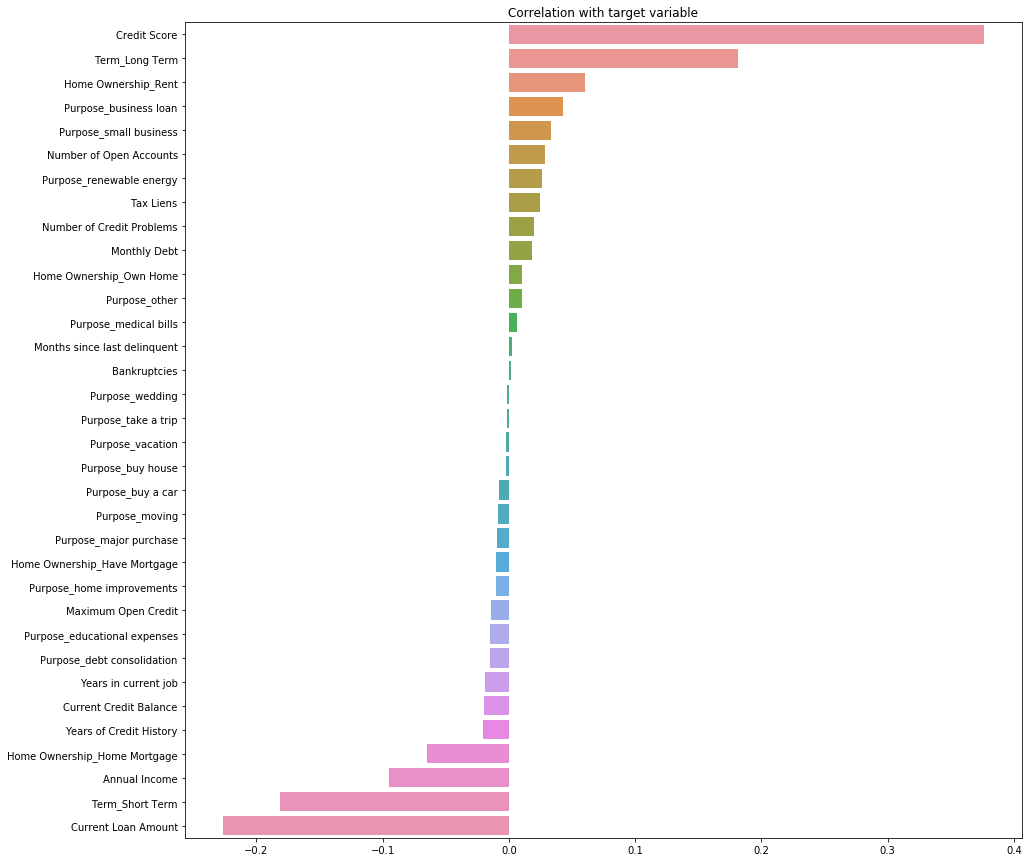

In [293]:
corr_with_target = df[BASE_FEATURE_NAMES + [TARGET_NAME]].corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(15, 15))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Correlation with target variable')
plt.show()

# Обработка выбросов

In [333]:
df.describe()

,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,...,Purpose_moving,Purpose_other,Purpose_renewable energy,Purpose_small business,Purpose_take a trip,Purpose_vacation,Purpose_wedding,Term_Long Term,Term_Short Term,ID
count,7.500000e+03,7.500000e+03,7500.000000,7.500000e+03,7.500000e+03,7.500000e+03,7.500000e+03,7.500000e+03,7.500000e+03,7.500000e+03,...,7.500000e+03,7.500000e+03,7.500000e+03,7.500000e+03,7.500000e+03,7.500000e+03,7.500000e+03,7.500000e+03,7.500000e+03,7500.000000
mean,1.252850e-16,-1.225834e-16,0.030133,1.692720e-16,1.191639e-16,-7.831652e-17,1.222888e-15,-4.435267e-16,-1.917873e-16,-7.543595e-17,...,-4.609165e-16,7.123339e-16,-3.824506e-16,-5.970354e-16,-2.277882e-16,-4.531375e-17,4.574915e-16,-3.342215e-16,3.342215e-16,3749.500000
std,1.000067e+00,1.000067e+00,0.271604,1.000067e+00,1.000067e+00,1.000067e+00,1.000067e+00,1.000067e+00,1.000067e+00,1.000067e+00,...,1.000067e+00,1.000067e+00,1.000067e+00,1.000067e+00,1.000067e+00,1.000067e+00,1.000067e+00,1.000067e+00,1.000067e+00,2165.207842
min,-1.533873e+00,-1.489549e+00,0.000000,-1.920789e+00,-2.053499e+00,-5.897941e-02,-3.409789e-01,-2.360021e+00,-3.370990e-01,-1.737904e+00,...,-3.832520e-02,-3.119188e-01,-1.633211e-02,-5.898073e-02,-7.041159e-02,-3.267730e-02,-4.476615e-02,-5.915167e-01,-1.690569e+00,0.000000
25%,-5.208805e-01,-9.565645e-01,0.000000,-6.465868e-01,-6.873744e-01,-4.155495e-02,-3.409789e-01,-1.185251e+00,-3.370990e-01,-7.522306e-01,...,-3.832520e-02,-3.119188e-01,-1.633211e-02,-5.898073e-02,-7.041159e-02,-3.267730e-02,-4.476615e-02,-5.915167e-01,-1.690569e+00,1874.750000
50%,-2.073461e-01,1.094039e-01,0.000000,-2.218527e-01,-1.840654e-01,-2.914137e-02,-3.409789e-01,6.748008e-01,-3.370990e-01,2.797669e-03,...,-3.832520e-02,-3.119188e-01,-1.633211e-02,-5.898073e-02,-7.041159e-02,-3.267730e-02,-4.476615e-02,-5.915167e-01,5.915167e-01,3749.500000
75%,2.308540e-01,1.175372e+00,0.000000,6.276153e-01,5.061870e-01,-9.463390e-03,-3.409789e-01,6.748008e-01,-3.370990e-01,5.125469e-01,...,-3.832520e-02,-3.119188e-01,-1.633211e-02,-5.898073e-02,-7.041159e-02,-3.267730e-02,-4.476615e-02,1.690569e+00,5.915167e-01,5624.250000
max,1.166117e+01,1.175372e+00,7.000000,4.025488e+00,4.561420e+00,8.135844e+01,1.369933e+01,1.457981e+00,1.119423e+01,2.800417e+00,...,2.609249e+01,3.205962e+00,6.122908e+01,1.695469e+01,1.420221e+01,3.060229e+01,2.233831e+01,1.690569e+00,5.915167e-01,7499.000000


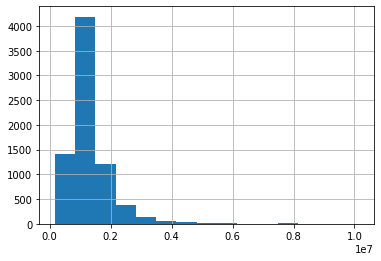

In [295]:
df['Annual Income'].hist(bins=15)

In [296]:
df['Tax Liens'].value_counts()

0.0    7366
1.0      83
2.0      30
3.0      10
4.0       6
5.0       2
6.0       2
7.0       1
Name: Tax Liens, dtype: int64

In [297]:
df.loc[df['Annual Income'] == '0', 'Annual Income'] = df['Annual Income'].mode()[0]


/home/user/anaconda3/lib/python3.7/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


In [298]:
df['Maximum Open Credit'].describe()

count    7.500000e+03
mean     9.451537e+05
std      1.602622e+07
min      0.000000e+00
25%      2.792295e+05
50%      4.781590e+05
75%      7.935015e+05
max      1.304726e+09
Name: Maximum Open Credit, dtype: float64

In [299]:
df.loc[(df['Credit Score'] <= 0) | (df['Credit Score'] > 800), 'Credit Score'] = df['Credit Score'].median()

Years of Credit History

In [300]:
df.loc[(df['Years of Credit History'] <= 0) | (df['Years of Credit History'] > 50), 'Years of Credit History'] = df['Years of Credit History'].median()

Number of Open Accounts

In [301]:
df.loc[(df['Number of Open Accounts'] <= 0) | (df['Number of Open Accounts'] > 30), 'Number of Open Accounts'] = df['Number of Open Accounts'].median()

Months since last delinquent

In [302]:
df.loc[(df['Months since last delinquent'] <= 0) | (df['Months since last delinquent'] > 40), 'Months since last delinquent'] = df['Number of Open Accounts'].median()

In [303]:
df['Current Loan Amount'].value_counts()

99999999.0    870
89298.0         6
218064.0        6
216106.0        5
270226.0        5
             ... 
490006.0        1
404756.0        1
194414.0        1
420376.0        1
33792.0         1
Name: Current Loan Amount, Length: 5386, dtype: int64

df.loc[df['Current Loan Amount'] > 999999, 'Current Loan Amount'] = 999999

In [304]:
df.loc[(df['Current Loan Amount'] > 999999), 'Current Loan Amount'] = df['Current Loan Amount'].median()

In [305]:
df['Current Loan Amount'].value_counts()

309573.0    870
89298.0       6
218064.0      6
216106.0      5
270226.0      5
           ... 
404756.0      1
194414.0      1
420376.0      1
303380.0      1
33792.0       1
Name: Current Loan Amount, Length: 5386, dtype: int64

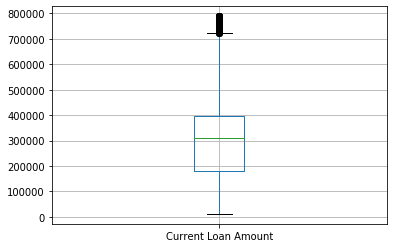

In [306]:
df.boxplot(column=['Current Loan Amount'])

In [308]:
df_num_features = df.select_dtypes(include='float64')

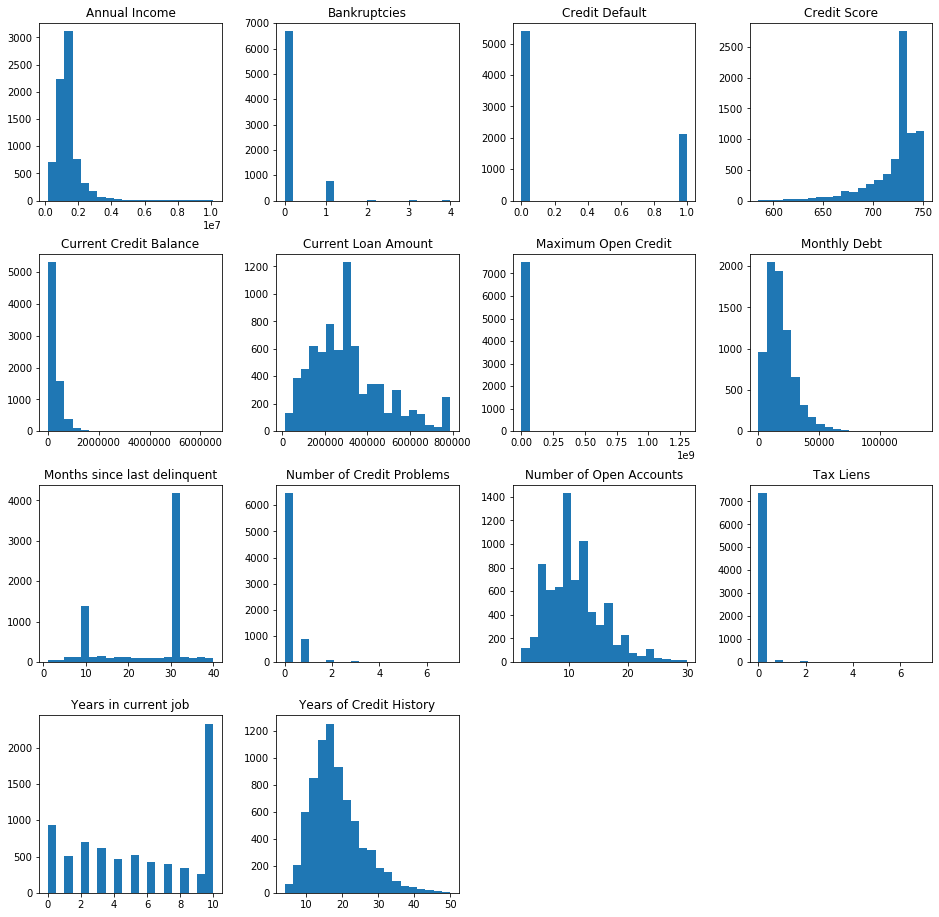

In [309]:
df_num_features.hist(figsize=(16,16), bins=20, grid=False);

# Отбор признаков

In [310]:
df['ID'] = df.index.tolist()

In [311]:
df.dtypes

Annual Income                   float64
Years in current job            float64
Tax Liens                       float64
Number of Open Accounts         float64
Years of Credit History         float64
Maximum Open Credit             float64
Number of Credit Problems       float64
Months since last delinquent    float64
Bankruptcies                    float64
Current Loan Amount             float64
Current Credit Balance          float64
Monthly Debt                    float64
Credit Score                    float64
Credit Default                  float64
Home Ownership_Have Mortgage      uint8
Home Ownership_Home Mortgage      uint8
Home Ownership_Own Home           uint8
Home Ownership_Rent               uint8
Purpose_business loan             uint8
Purpose_buy a car                 uint8
Purpose_buy house                 uint8
Purpose_debt consolidation        uint8
Purpose_educational expenses      uint8
Purpose_home improvements         uint8
Purpose_major purchase            uint8


In [312]:
df_test.head()

,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,...,Purpose_medical bills,Purpose_moving,Purpose_other,Purpose_renewable energy,Purpose_small business,Purpose_take a trip,Purpose_vacation,Purpose_wedding,Term_Long Term,Term_Short Term
0,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,99999999.0,...,0,0,0,0,0,0,0,0,0,1
1,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,264968.0,...,0,0,0,0,0,0,0,0,1,0
2,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,99999999.0,...,0,0,0,0,0,0,0,0,0,1
3,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,121396.0,...,0,0,0,0,0,0,0,0,0,1
4,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,125840.0,...,0,0,0,0,0,0,0,0,0,1


In [313]:
df.head()

,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,...,Purpose_moving,Purpose_other,Purpose_renewable energy,Purpose_small business,Purpose_take a trip,Purpose_vacation,Purpose_wedding,Term_Long Term,Term_Short Term,ID
0,482087.0,0.0,0.0,11.0,26.3,685960.0,1.0,32.0,1.0,309573.0,...,0,0,0,0,0,0,0,0,1,0
1,1025487.0,10.0,0.0,15.0,15.3,1181730.0,0.0,32.0,0.0,264968.0,...,0,0,0,0,0,0,0,1,0,1
2,751412.0,8.0,0.0,11.0,35.0,1182434.0,0.0,32.0,0.0,309573.0,...,0,0,0,0,0,0,0,0,1,2
3,805068.0,6.0,0.0,8.0,22.5,147400.0,1.0,32.0,1.0,121396.0,...,0,0,0,0,0,0,0,0,1,3
4,776264.0,8.0,0.0,13.0,13.6,385836.0,1.0,32.0,0.0,125840.0,...,0,0,0,0,0,0,0,0,1,4


In [314]:
df_test['ID'] = df.index.tolist()

In [315]:
TARGET_NAME = 'Credit Default'
BASE_FEATURE_NAMES = df.columns.drop(TARGET_NAME).tolist()
NEW_FEATURE_NAMES = df_test.columns.drop([TARGET_NAME, 'ID'] + BASE_FEATURE_NAMES).tolist()

In [316]:
NUM_FEATURE_NAMES = [
'Annual Income',
'Years in current job',
'Number of Open Accounts',
'Years of Credit History',
'Maximum Open Credit',
'Number of Credit Problems',
'Months since last delinquent',
'Bankruptcies',
'Current Loan Amount',
'Current Credit Balance',
'Monthly Debt',
'Purpose_moving',
'Purpose_other',
'Purpose_renewable energy',
'Purpose_small business',
'Purpose_take a trip',
'Purpose_vacation',
'Purpose_wedding',
'Term_Long Term',
'Term_Short Term'    
]

CAT_FEATURE_NAMES = ['Credit Default']

SELECTED_FEATURE_NAMES = NUM_FEATURE_NAMES + NEW_FEATURE_NAMES

In [317]:
for colname in CAT_FEATURE_NAMES:
    df[colname] = pd.Categorical(df[colname])
    
df[CAT_FEATURE_NAMES].dtypes

Credit Default    category
dtype: object

In [318]:
df['Tax Liens']

0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
7495    0.0
7496    0.0
7497    0.0
7498    0.0
7499    0.0
Name: Tax Liens, Length: 7500, dtype: float64

In [319]:
scaler = StandardScaler()

df_norm = df.copy()
df_norm[NUM_FEATURE_NAMES] = scaler.fit_transform(df_norm[NUM_FEATURE_NAMES])

df = df_norm.copy()

In [320]:
X = df[SELECTED_FEATURE_NAMES]
y = df[TARGET_NAME]

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.30, random_state=21)

In [321]:
train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)

In [322]:
model_lr = LogisticRegression()
model_lr.fit(X_train, y_train)

y_train_pred = model_lr.predict(X_train)
y_test_pred = model_lr.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

         0.0       0.73      0.98      0.84      3771
         1.0       0.61      0.09      0.16      1479

    accuracy                           0.73      5250
   macro avg       0.67      0.53      0.50      5250
weighted avg       0.70      0.73      0.65      5250

TEST

              precision    recall  f1-score   support

         0.0       0.73      0.98      0.84      1616
         1.0       0.61      0.07      0.12       634

    accuracy                           0.73      2250
   macro avg       0.67      0.53      0.48      2250
weighted avg       0.70      0.73      0.64      2250

CONFUSION MATRIX

col_0            0.0  1.0
Credit Default           
0.0             1589   27
1.0              591   43


In [323]:
model_knn = KNeighborsClassifier()
model_knn.fit(X_train, y_train)

y_train_pred = model_knn.predict(X_train)
y_test_pred = model_knn.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

         0.0       0.80      0.93      0.86      3771
         1.0       0.68      0.40      0.50      1479

    accuracy                           0.78      5250
   macro avg       0.74      0.66      0.68      5250
weighted avg       0.77      0.78      0.76      5250

TEST

              precision    recall  f1-score   support

         0.0       0.73      0.86      0.79      1616
         1.0       0.36      0.20      0.26       634

    accuracy                           0.67      2250
   macro avg       0.55      0.53      0.52      2250
weighted avg       0.63      0.67      0.64      2250

CONFUSION MATRIX

col_0            0.0  1.0
Credit Default           
0.0             1390  226
1.0              507  127


In [324]:
model_xgb = xgb.XGBClassifier(random_state=21)
model_xgb.fit(X_train, y_train)

y_train_pred = model_xgb.predict(X_train)
y_test_pred = model_xgb.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

         0.0       0.96      1.00      0.98      3771
         1.0       1.00      0.89      0.94      1479

    accuracy                           0.97      5250
   macro avg       0.98      0.94      0.96      5250
weighted avg       0.97      0.97      0.97      5250

TEST

              precision    recall  f1-score   support

         0.0       0.75      0.87      0.81      1616
         1.0       0.45      0.27      0.34       634

    accuracy                           0.70      2250
   macro avg       0.60      0.57      0.57      2250
weighted avg       0.67      0.70      0.67      2250

CONFUSION MATRIX

col_0            0.0  1.0
Credit Default           
0.0             1403  213
1.0              461  173


In [325]:
model_lgbm = lgbm.LGBMClassifier(random_state=21)
model_lgbm.fit(X_train, y_train)

y_train_pred = model_lgbm.predict(X_train)
y_test_pred = model_lgbm.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

         0.0       0.86      0.99      0.92      3771
         1.0       0.96      0.60      0.74      1479

    accuracy                           0.88      5250
   macro avg       0.91      0.79      0.83      5250
weighted avg       0.89      0.88      0.87      5250

TEST

              precision    recall  f1-score   support

         0.0       0.75      0.91      0.82      1616
         1.0       0.50      0.22      0.31       634

    accuracy                           0.72      2250
   macro avg       0.63      0.57      0.57      2250
weighted avg       0.68      0.72      0.68      2250

CONFUSION MATRIX

col_0            0.0  1.0
Credit Default           
0.0             1477  139
1.0              493  141


In [326]:
model_catb = catb.CatBoostClassifier(silent=True, random_state=21)
model_catb.fit(X_train, y_train)

y_train_pred = model_catb.predict(X_train)
y_test_pred = model_catb.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

         0.0       0.82      0.99      0.90      3771
         1.0       0.93      0.47      0.62      1479

    accuracy                           0.84      5250
   macro avg       0.88      0.73      0.76      5250
weighted avg       0.86      0.84      0.82      5250

TEST

              precision    recall  f1-score   support

         0.0       0.74      0.93      0.82      1616
         1.0       0.48      0.18      0.26       634

    accuracy                           0.72      2250
   macro avg       0.61      0.55      0.54      2250
weighted avg       0.67      0.72      0.66      2250

CONFUSION MATRIX

col_0            0.0  1.0
Credit Default           
0.0             1496  120
1.0              521  113


In [327]:
%%time

final_model = catb.CatBoostClassifier(n_estimators=500, max_depth=3,
                                      silent=True, random_state=21)
final_model.fit(X_train, y_train)

y_train_pred = final_model.predict(X_train)
y_test_pred = final_model.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)


TRAIN

              precision    recall  f1-score   support

         0.0       0.76      0.97      0.85      3771
         1.0       0.74      0.22      0.34      1479

    accuracy                           0.76      5250
   macro avg       0.75      0.60      0.60      5250
weighted avg       0.75      0.76      0.71      5250

TEST

              precision    recall  f1-score   support

         0.0       0.74      0.95      0.83      1616
         1.0       0.52      0.15      0.23       634

    accuracy                           0.72      2250
   macro avg       0.63      0.55      0.53      2250
weighted avg       0.68      0.72      0.66      2250

CONFUSION MATRIX

col_0            0.0  1.0
Credit Default           
0.0             1531   85
1.0              541   93
CPU times: user 2.81 s, sys: 163 ms, total: 2.97 s
Wall time: 808 ms


In [328]:
def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
       
    plt.figure(figsize = (20, len(feature_importances) * 0.355))
    
    sns.barplot(feature_importances['importance'], feature_importances['feature'])
    
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()

    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()

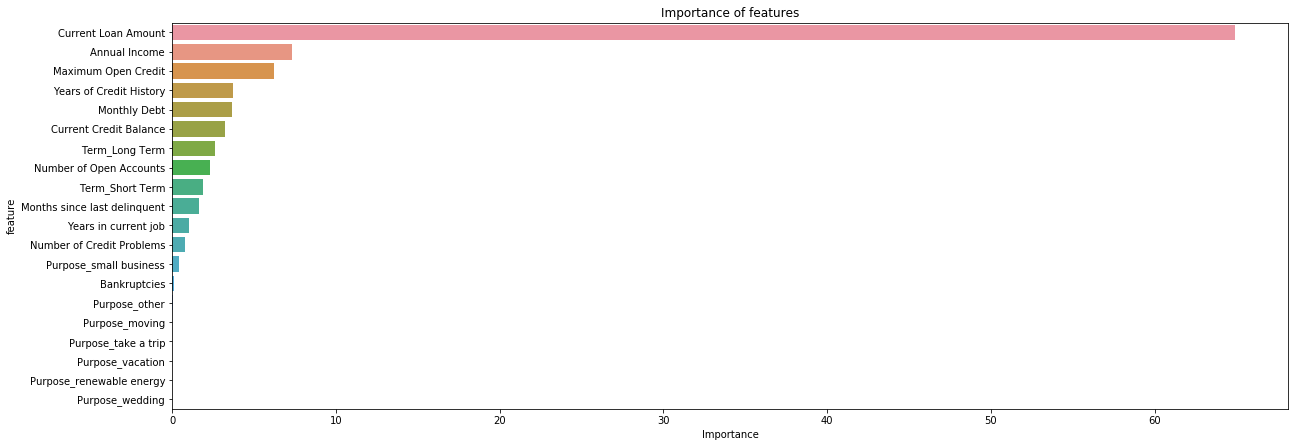

In [329]:
final_model.fit(X_train, y_train)
important_features_top = show_feature_importances(X_train.columns, final_model.feature_importances_, get_top=25)

In [330]:
final_model = catb.CatBoostClassifier(n_estimators=500, max_depth=3,
                                      silent=True, random_state=40)
final_model.fit(X_train, y_train)

y_train_pred = final_model.predict(X_train[important_features_top])
y_test_pred = final_model.predict(X_test[important_features_top])
y_test_pred_probs = final_model.predict_proba(X_test[important_features_top])

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

         0.0       0.76      0.97      0.85      3771
         1.0       0.74      0.23      0.35      1479

    accuracy                           0.76      5250
   macro avg       0.75      0.60      0.60      5250
weighted avg       0.76      0.76      0.71      5250

TEST

              precision    recall  f1-score   support

         0.0       0.74      0.94      0.83      1616
         1.0       0.51      0.14      0.22       634

    accuracy                           0.72      2250
   macro avg       0.62      0.54      0.53      2250
weighted avg       0.67      0.72      0.66      2250

CONFUSION MATRIX

col_0            0.0  1.0
Credit Default           
0.0             1527   89
1.0              543   91


/home/user/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


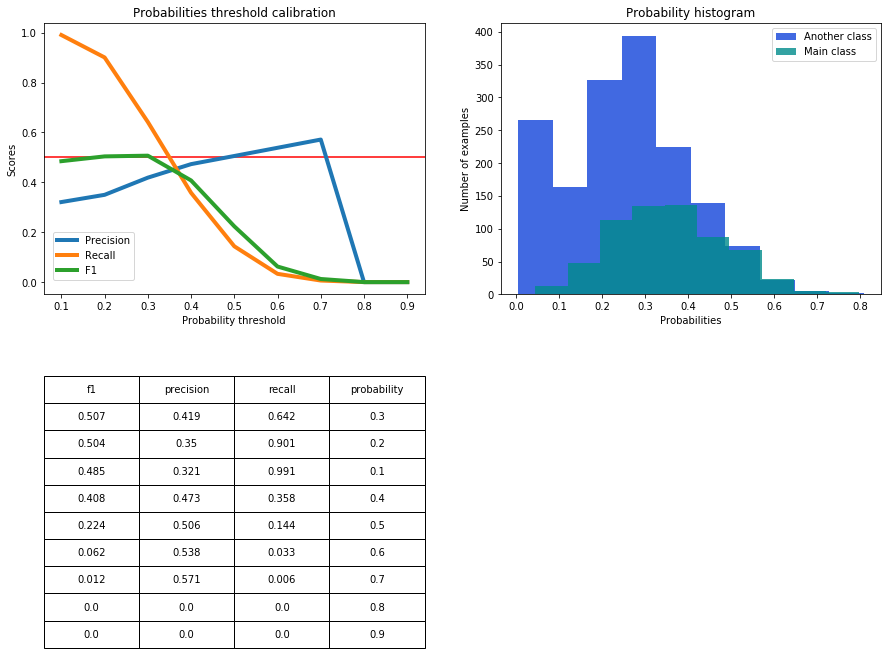

In [332]:
show_proba_calibration_plots(y_test_pred_probs[:, 1], y_test)